In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import os 
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.4.0'
from rpy2.robjects import pandas2ri
import anndata2ri

sys.path.insert(0, '../')

import sc_average_overlap as ao

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# These are required in order to run Piccolo in R with this notebook
#pandas2ri.activate()
#anndata2ri.activate()
#%load_ext rpy2.ipython

In [4]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

## Import thymus data

In [5]:
adata_all = sc.read_10x_mtx(
    'data/wt_thymus_data/WT/',
    var_names='gene_symbols',
    prefix='GSM4721907_WT_',
)
adata_all.var_names_make_unique()

In [6]:
adata_all

AnnData object with n_obs × n_vars = 8931 × 31053
    var: 'gene_ids', 'feature_types'

We first generated log-normalized counts in python.

In [7]:
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)

### Running Piccolo for normalization and feature selection

Next we read data in R and run Piccolo. These go into the actual anndata we'll work with.

The prerequisites to perform these tasks are to first install `rpy2` and `anndata2ri`. Installation and setup instructions for `rpy2` can be found [here](https://rpy2.github.io/), while `anndata2ri` can be found [here](https://github.com/theislab/anndata2ri).

Next, Piccolo must be installed. Instructions can be found on its [Github repository](https://github.com/Amartya101/Piccolo). Additionally, [Seurat](https://github.com/satijalab/seurat) and [SingleCellExperiment](https://bioconductor.org/packages/release/bioc/html/SingleCellExperiment.html) must be installed as well, as `anndata2ri` provides an interface to convert SingleCellExperiment objects in R to AnnData objects in Python, while Seurat is used a link between Piccolo and SingleCellExperiment objects.

*Note the code below is commented out, as we show this run of Piccolo for demonstration purposes. For future analysis, we have saved Piccolo counts into a CSV file, from which we will define our main AnnData object.

In [8]:
#%%R -o adata_wt

#library(Piccolo)
#library(Seurat)
#library(SingleCellExperiment)

#options(future.globals.maxSize = 8000 * 1024^2)

#adata_wt <- CreatePiccoloList(
#  MTX = "data/wt_thymus_data/WT/GSM4721907_WT_matrix.mtx.gz", 
#  Genes = "data/wt_thymus_data/WT/GSM4721907_WT_features.tsv",
#  Barcodes = "data/wt_thymus_data/WT/GSM4721907_WT_barcodes.tsv"
#)

#adata_wt <- FilterCells(
#  PiccoloList = adata_wt,
#  MinFeaturesPerCell = 100,
#  MT.Perc = 12, # default value is 12
#  RP.Perc = 80,
#  TotalCountsMADLow = NULL,
#  TotalCountsMADHigh = NULL
#)

#adata_wt <- PrepareCountsForSeurat(PiccoloList = adata_wt)
#adata_wt <- CreateSeuratObject(counts = adata_wt$Counts)

#adata_wt <- SCTransform(object = adata_wt, vst.flavor = "v2")
#adata_wt <- SelectFeaturesForSeurat(Obj = adata_wt, NoOfHVG = 3000) 
#adata_wt <- NormalizeForSeurat(Obj = adata_wt)

#adata_wt <- as.SingleCellExperiment(adata_wt)

In [9]:
#adata_wt # This is the adata_wt that comes out of Piccolo and rpy2

In [10]:
# piccolo_counts_df = pd.DataFrame(adata_wt.layers['scaledata'], index=adata_wt.obs_names, columns=adata_wt.var_names)
# piccolo_counts_df.to_csv("data/wt_thymus_data/piccolo_counts.csv")

### Alternative: import saved Piccolo counts from a CSV file

Alternatively, assuming that we have saved Piccolo counts into a separate CSV file, we can import those and define `adata_wt` using this input file.

In [11]:
piccolo_counts_df = pd.read_csv("data/wt_thymus_data/piccolo_counts.csv", index_col=0)
adata_wt = ad.AnnData(piccolo_counts_df)
adata_wt.obs_names = piccolo_counts_df.index
adata_wt.var_names = piccolo_counts_df.columns

adata_wt

AnnData object with n_obs × n_vars = 7969 × 2996

Piccolo output has now been converted to an AnnData object. We will combine the Piccolo residuals with the log-norm counts we determined earlier

In [12]:
adata_all = adata_all[adata_wt.obs_names].copy() # some cells got filtered out in Piccolo. 
adata_all

AnnData object with n_obs × n_vars = 7969 × 31053
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'

In [13]:
adata_wt.raw = adata_all # replace raw attribute of adata_wt with 'raw' lognormed counts
# adata_wt.X = adata_wt.layers['scaledata']

We have the Piccolo residuals in 'scaledata', now we can run the usual PCA + downstream analysis using them

In [14]:
n_pcs = 51
sc.pp.pca(adata_wt, svd_solver="arpack", n_comps=100)
sc.pp.neighbors(adata_wt, n_neighbors=10, n_pcs=n_pcs, use_rep='X_pca', )
sc.tl.umap(adata_wt)

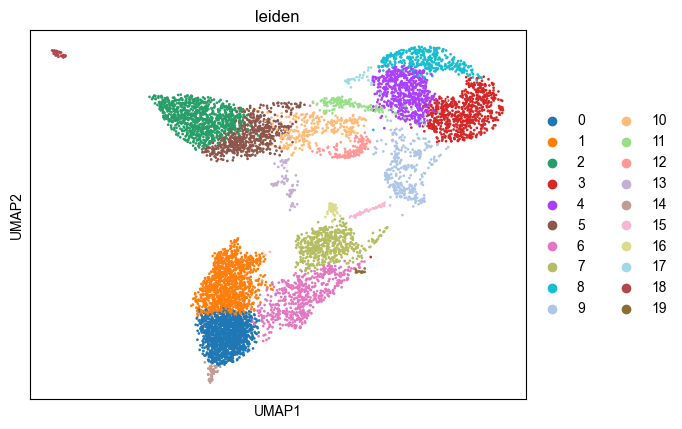

In [15]:
sc.tl.leiden(adata_wt, resolution=1)
sc.pl.umap(adata_wt, color=['leiden'],  )

In [16]:
# Reorder leiden labels to better align with T cell trajectory
leiden_relabel = {
    '13': '0',
    '10': '1',
    '12': '2',
    '5': '3',
    '2': '4',
    '11': '5',
    '4': '6',
    '8': '7',
    '17': '8',
    '3': '9',
    '9': '10',
    '15': '11',
    '1': '12',
    '0': '13',
    '14': '14',
    '6': '15',
    '7': '16',
    '16': '17',
    '19': '18',
    '18': '19'
}


adata_wt.obs['leiden_reordered'] = adata_wt.obs['leiden']
adata_wt.obs['leiden_reordered'] = (
    adata_wt.obs['leiden_reordered']
    .map(lambda x: leiden_relabel.get(x, x)) # get() with 2 arguments returns the key itself if it doesn't exist in dict
    .astype('category')
)

adata_wt.obs['leiden_reordered'] = pd.Categorical(
    values=adata_wt.obs.leiden_reordered, categories=adata_wt.obs['leiden'].cat.categories.to_list(), ordered=True
)

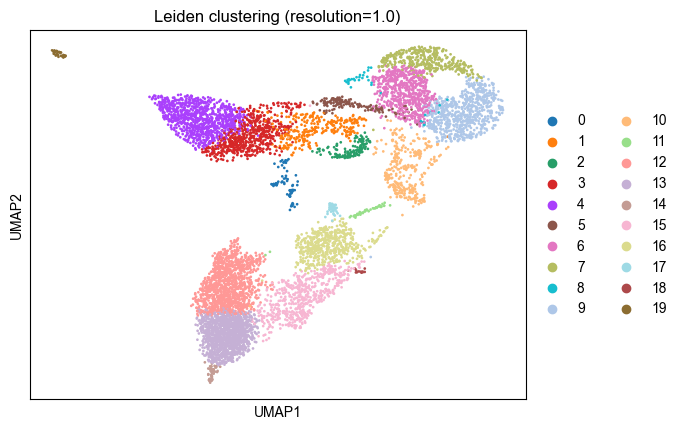

In [17]:
sc.pl.umap(adata_wt, color=['leiden_reordered'], title='Leiden clustering (resolution=1.0)', )

We found in our analysis with ImmGen and [MyGeneSet](https://rstats.immgen.org/MyGeneSet_New/index.html) that some cells mapped closely to granulocytes (cluster 19) or B cells. We show high expression of B cell marker genes below.

We will filter these cells out as we are only interested in cells belonging to T cell lineage.

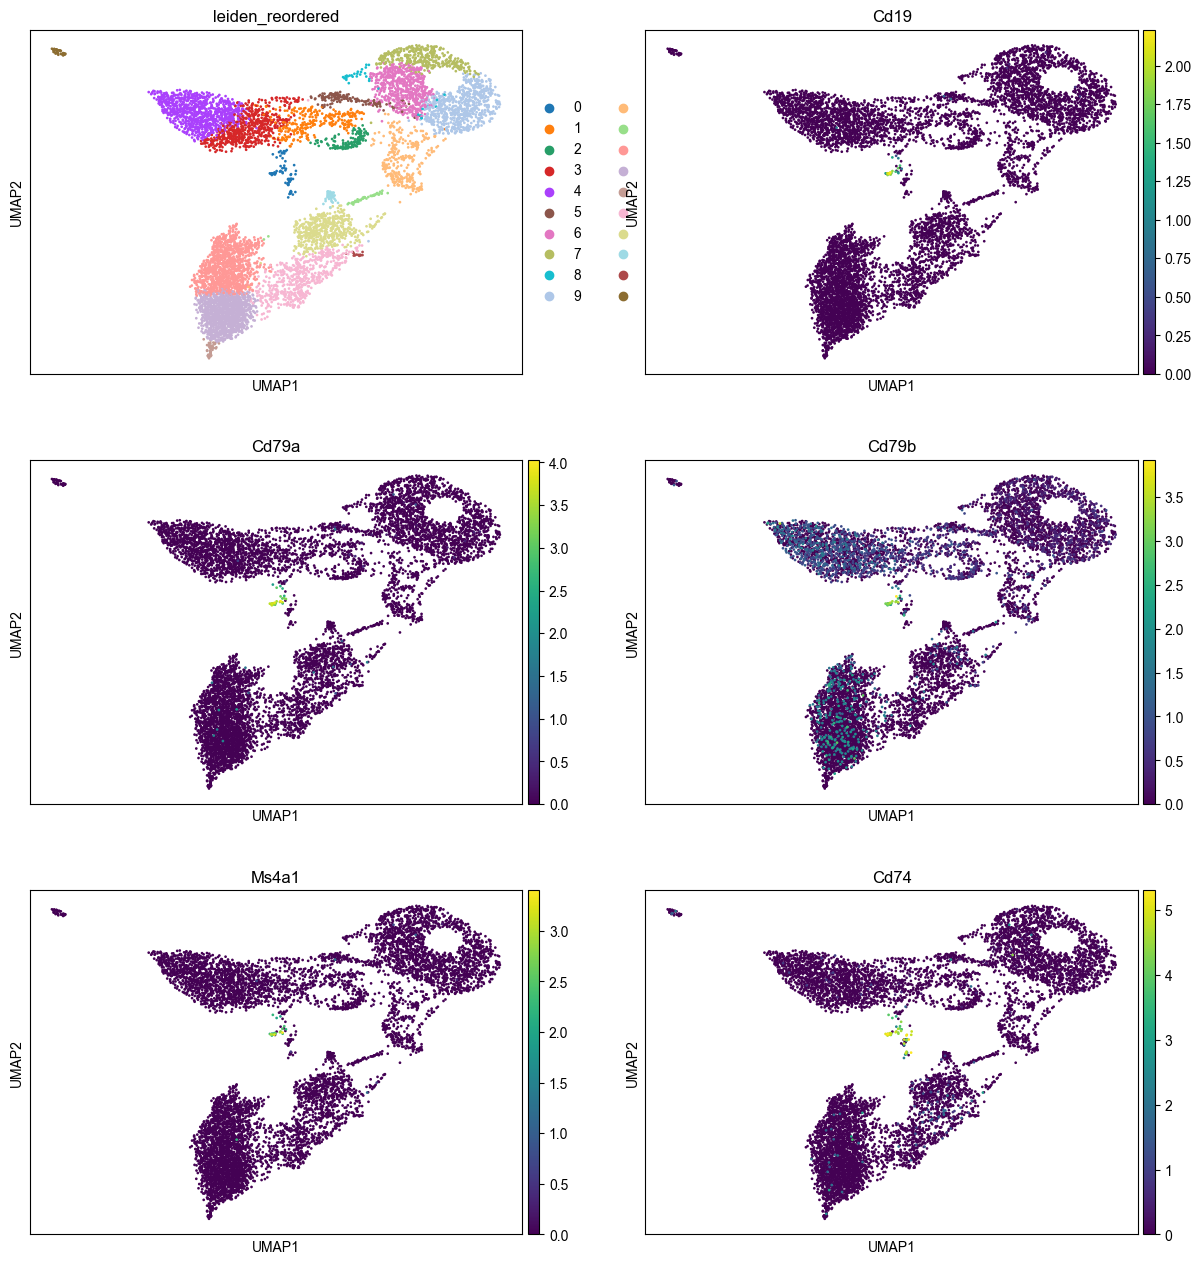

In [18]:
sc.pl.umap(adata_wt, 
           color=['leiden_reordered',  'Cd19', 'Cd79a', 'Cd79b', 'Ms4a1', 'Cd74'], ncols=2, 
           )

In [19]:
# create a B-cell 'signature'
b_cell_markers = ['Cd19', 'Cd79a', 'Cd79b', 'Ms4a1', 'Cd74', ]
sc.tl.score_genes(adata_wt, b_cell_markers, score_name='B_cell_score')

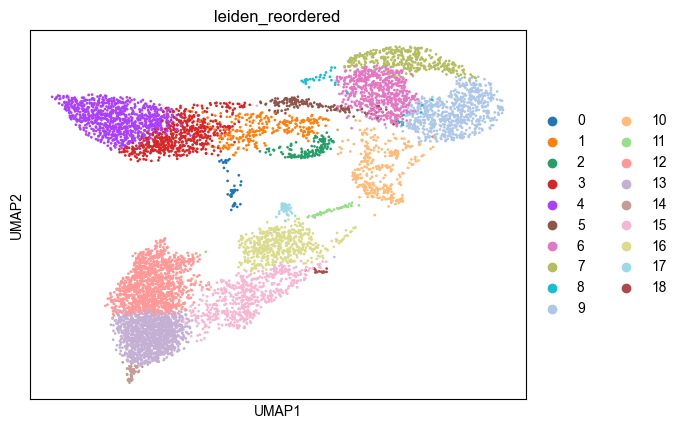

In [20]:
# Actually filter out cells
adata_wt = adata_wt[adata_wt.obs['B_cell_score'] < 1.0] # Obvious b cells are out
adata_wt = adata_wt[adata_wt.obs['leiden_reordered'] != '19'] # Obvious granulocytes are out
sc.pl.umap(adata_wt, color='leiden_reordered', )

This UMAP plot of the Leiden clusters corresponds to **Figure 2A** in our manuscript.

We now run differential expression as a further downstream analysis.

In [21]:
cat = 'leiden_reordered'
sc.tl.rank_genes_groups(adata_wt, groupby=cat, method='wilcoxon', tie_correct=True, use_raw=True, pts=True)

## Cell cycle signature

We investigated the cell cycle in our dataset, as cell cycel genes were found in many cluster's top differentially expressed genes. We used a widely-used list of cell cycle genes corresponding to each cell cycle phase from [Tirosh et al.](https://www.science.org/doi/10.1126/science.aad0501)

This plot corresponds to **Figure 2C** in our manuscript.

In [22]:
cell_cycle_genes = [x.strip().capitalize() for x in open('data/cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

sc.tl.score_genes_cell_cycle(adata_wt, s_genes=s_genes, g2m_genes=g2m_genes)

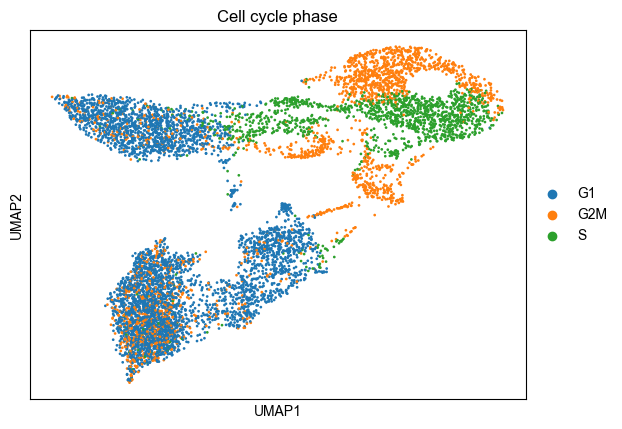

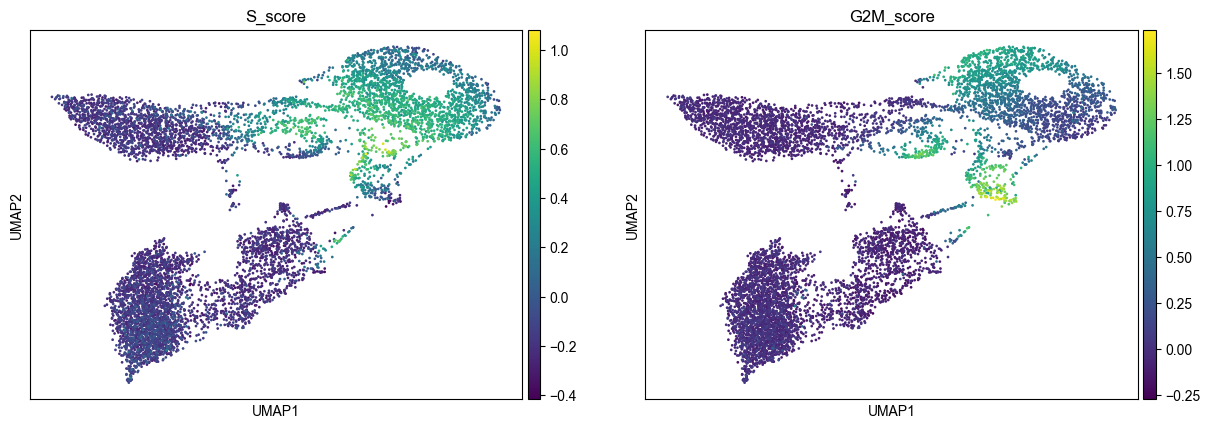

In [23]:
sc.pl.umap(adata_wt, color=['phase', ], title='Cell cycle phase')
sc.pl.umap(adata_wt, color=['S_score', 'G2M_score', ])

### Plot cluster marker gene expression in ImmGen populations

To facilitate annotation of our clusters, we plotted the expression our cluster marker genes in sorted thymoctye populations in the Immunological Genome Project, using the [MyGeneSet](https://rstats.immgen.org/MyGeneSet_New/index.html) tool.

We took the top 50 differentially expressed genes in each cluster and used them as input to the MyGeneSet tool.

Afterward, we downloaded the expression values of each cluster's marker genes in the bulk populations as a JSON file, which we process and compute composite z-scores for. The resulting summary heatmap corresponds to **Figure 2D** in our manuscript.

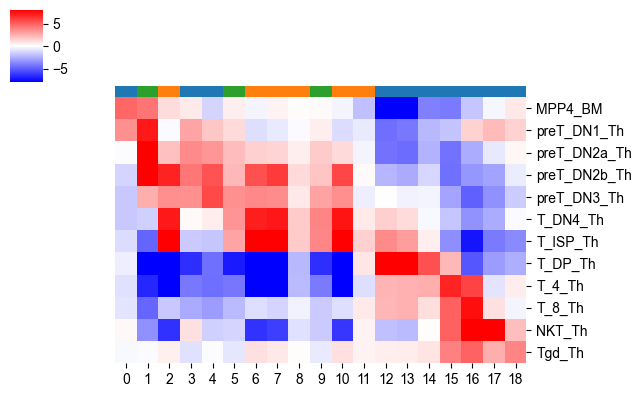

In [24]:
from matplotlib.patches import Patch
import json 

directory = 'data/wt_thymus_data/leiden_markers_in_immgen_thymocytes'
file_list = [ str(i) for i in range(0, 19)]
df_dict = {}
row_labels = []
genes_dict = {}

for f_name in file_list:
    f = open(directory + '/' + f_name + '.json')
    data = json.load(f)

    nrows = len(data['rowLabel'])
    ncols = len(data['colLabel'])
    expression_matrix = np.empty( (nrows, ncols) )

    for d in data['data']:
        x = d['row_id'] - 1
        y = d['col_id'] - 1
        expression_matrix[x, y] = d['value']

    # Make sure there's no whitespace in our row labels
    row_labels = data['rowLabel']
    row_labels = [s.strip() for s in row_labels]
    df = pd.DataFrame(expression_matrix, index=row_labels, columns=data['colLabel']).round(3)

    df_dict[f_name.split('.')[0]] = df
    row_labels += [f_name.split('.')[0]] * nrows
    genes_dict[f_name.split('.')[0]] = df.index.to_list()

df_total = pd.concat([ df for df in df_dict.values()], )

# Calculate composite zscores. 
df_total = np.log10(df_total + 1)
std = np.std(df_total.to_numpy().flatten())
df_total = df_total.sub(df_total.mean(axis=1), axis=0) / std 

df_composite_scores = pd.DataFrame(columns=df_total.columns)
for cluster in genes_dict.keys():
    genes_to_summarize = genes_dict[cluster]
    l = len(genes_to_summarize)
    df_composite_scores.loc[cluster] = df_total.loc[genes_to_summarize].sum(axis=0) / np.sqrt(l)

cols_to_rename = {
    df_composite_scores.columns[0]: "MPP4_BM",
    df_composite_scores.columns[-2]: "NKT_Th",
    df_composite_scores.columns[-1]: "Tgd_Th"
}
df_composite_scores = df_composite_scores.rename(columns=cols_to_rename)
df_composite_scores = df_composite_scores.transpose()

# For coloring by cell cycle
leiden_clusters = adata_wt.obs['leiden_reordered'].cat.categories
colors = {'G1': 'C0', 'G2M': 'C1', 'S': 'C2'}
phase_annotation = {}
for l in leiden_clusters:
    df_temp = adata_wt[adata_wt.obs['leiden_reordered'] == l].obs
    phase_annotation[l] = colors[df_temp['phase'].mode()[0]]
col_colors = leiden_clusters.map(phase_annotation)

ax = sns.clustermap(df_composite_scores, vmin=-8, vmax=8,
    row_cluster=False,
    col_cluster=False,
    cmap='bwr',
    col_colors=col_colors,
    annot=False, annot_kws={'size': 8},
    figsize=(6.5,4)
)

plt.show()

### Construct the average overlap tree

Previously we ran differential expression analysis, using the Wilcoxon rank-sum test. Now, we combine all clusters' top 25 DE genes into a single set to be ranked by each cluster. These rankings are what AO-based hierarchical clustering will use.

In [25]:
cat = 'leiden_reordered'

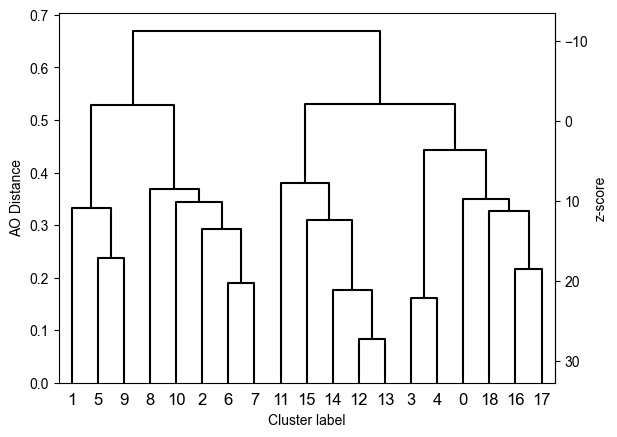

In [26]:
marker_gene_set = ao.get_all_cluster_markers(adata_wt, cat, n_genes=25)
ao.make_ao_dendrogram(adata_wt, groupby=cat, genes_to_filter=marker_gene_set)

_, ax = ao.plot_ao_dendrogram(adata_wt, key=cat)
plt.show()

This cluster tree corresponds to **Figure 2B** in our manuscript.

We then assign annotations based on expression of markers in ImmGen bulk sorted populations of thymoctyes. These coincide with cluster merges that can be informed from inspecting the most similar cluster that appear in our AO cluster tree.

In [27]:
merge_1_dict = {
    '13': '12',
    '4': '3',
    '14': '12',
    '7': '6',
}

adata_wt.obs['leiden_2'] = adata_wt.obs['leiden_reordered']
adata_wt.obs['leiden_2'] = (
    adata_wt.obs['leiden_2']
    .map(lambda x: merge_1_dict.get(x, x)) # get() with 2 arguments returns the key itself if it doesn't exist in dict
    .astype('category')
)

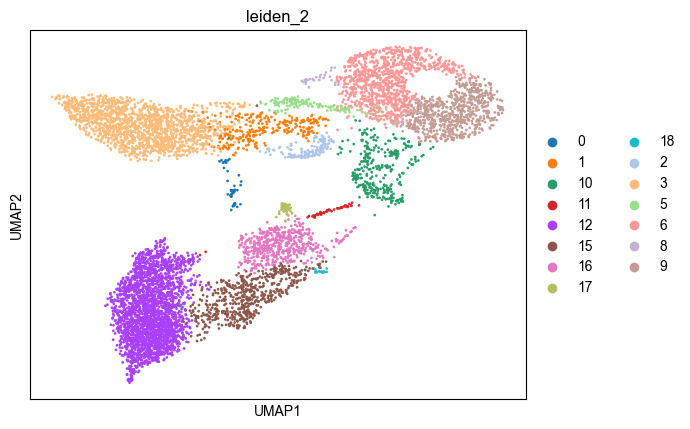

In [28]:
sc.pl.umap(adata_wt, color=['leiden_2'])

In [29]:
annotation_dict = {
    '3': 'DN3a',
    '1': 'DN2a',
    '2': 'DN2b',
    '0': 'MPP/DN1',
    '5': 'DN3b',
    '6': 'DN4/ISP (G2/M phase)',
    '9': 'DN4/ISP (S phase)',
    '10': 'ISP',
    '11': 'ISP to DP',
    '12': 'DP',
    '15': 'CD4 T',
    '16': 'CD8 T',
    '17': 'NK cell',
    '18': 'gd T',
    '8': 'DN4/ISP (G2/M phase) - Apoptotic'
}

adata_wt.obs['final_annotation'] = adata_wt.obs['leiden_2']
adata_wt.obs['final_annotation'] = (
    adata_wt.obs['final_annotation']
    .map(lambda x: annotation_dict.get(x, x)) # get() with 2 arguments returns the key itself if it doesn't exist in dict
    .astype('category')
)

ordered_annotations = ['MPP/DN1', 'DN2a', 'DN2b', 'DN3a', 'DN3b', 'DN4/ISP (S phase)', 'DN4/ISP (G2/M phase)', 
                       'DN4/ISP (G2/M phase) - Apoptotic', 'ISP', 'ISP to DP', 'DP', 'CD4 T', 'CD8 T', 'NK cell', 'gd T']

adata_wt.obs['final_annotation'] = pd.Categorical(
    values=adata_wt.obs.final_annotation, categories=ordered_annotations, ordered=True
)

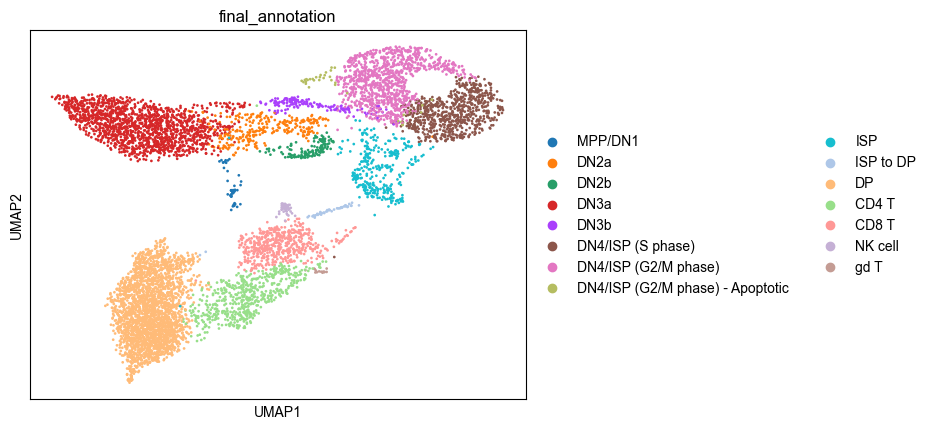

In [30]:
sc.pl.umap(adata_wt, color=['final_annotation'])

This UMAP of the final annotations of our thymus data correspond to **Figure 2E** in our manuscript.

## Supplementary analysis

### Comparison of DN3a v/s DN3b marker expression

To interrogate the presence of DN3a and DN3b populations, as ImmGen only contained sorted DN3 populations, we used upregulated genes in a study by Vogel et al. The genes come from their DESeq2 analysis, found at [GSE79174](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE79174).

These plots correspond to **Supplementary Figure 3** in our manuscript.

       'C130036L24Rik', 'F730043M19Rik', 'Gm37206', 'Gm14735', 'Gm37274',
       'Gbp11', 'A330023F24Rik', '1810053B23Rik'],
      dtype='object')


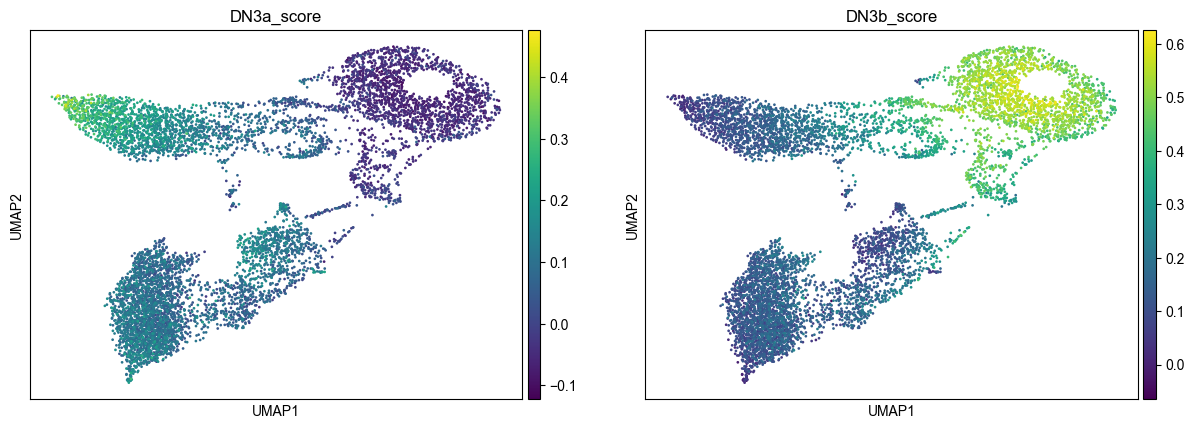

In [31]:
dn3a_gene_set = []
dn3b_gene_set = []

with open('data/3a_genes.txt') as file:
    dn3a_gene_set = [line.rstrip() for line in file]
    
with open('data/3b_genes.txt') as file:
    dn3b_gene_set = [line.rstrip() for line in file]
    
sc.tl.score_genes(adata_wt, dn3a_gene_set, score_name='DN3a_score', ctrl_size=len(dn3a_gene_set))
sc.tl.score_genes(adata_wt, dn3b_gene_set, score_name='DN3b_score', ctrl_size=len(dn3b_gene_set))

sc.pl.umap(adata_wt, color=['DN3a_score', 'DN3b_score'], ncols=2, )

### Running diffusion pseudotime

We investigated whether running a pseudotime algorithm would yield double negative development trajectories that match our final annotated stages of T-cell development. Using diffusion pseudotime, we found that starting at cluster results in pseudotime values that align with DN development.

However, upon starting at cluster 2, we see that pseudotime is confounded by the strength of the cell cycle signatures, notably assigning cells in clusters 6 and 7 to the same starting pseudotime. Therefore, we conclude that pseudotime algorithms are very sensitive to cell cycle gene expression, which we have demonstrated plays a large role in cluster identity.

These plots correspond to **Supplementary Figure 6**.

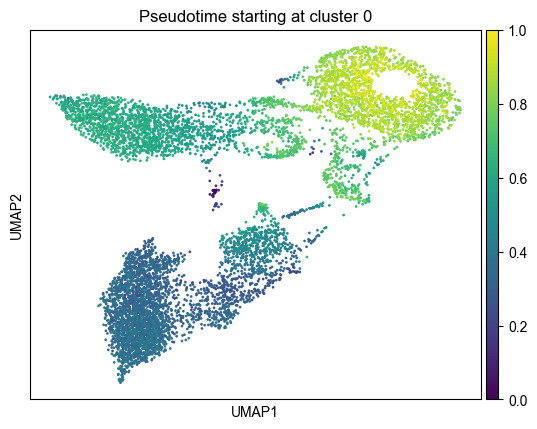

In [32]:
adata_wt.uns["iroot"] = np.flatnonzero(adata_wt.obs["leiden_reordered"] == "0")[0]
sc.tl.dpt(adata_wt)
sc.pl.umap(adata_wt, color=['dpt_pseudotime'], ncols=1, title='Pseudotime starting at cluster 0')

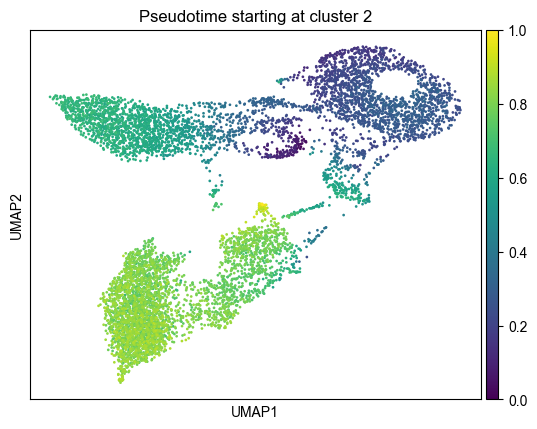

In [33]:
adata_wt.uns["iroot"] = np.flatnonzero(adata_wt.obs["leiden_reordered"] == "2")[0]
sc.tl.dpt(adata_wt)
sc.pl.umap(adata_wt, color=['dpt_pseudotime'], ncols=1, title='Pseudotime starting at cluster 2')

### Constructing a cluster tree with Pearson correlation instead of AO

We compare the relationships between clusters defined by AO, versus when the default of Pearson correlation for hierarchical clustering is used.

We base this code off of how hierarchical clustering is performed in Scanpy's `sc.tl.dendrogram` function.

This figure corresponds to **Supplementary Figure 7** in our manuscript.

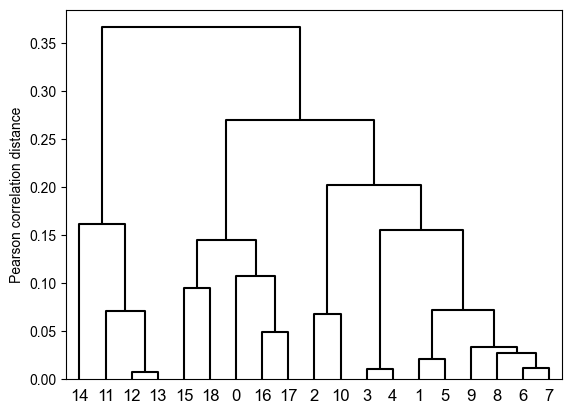

In [34]:
# Comparison to pearson tree
import scipy.cluster.hierarchy as sch
from scipy.spatial import distance

cat = 'leiden_reordered'

marker_gene_set = ao.get_all_cluster_markers(adata_wt, 'leiden_reordered', n_genes=25)

categories, rep_df = sc.pl._anndata._prepare_dataframe(adata_wt, var_names=list(marker_gene_set), groupby=cat, use_raw=True)
mean_df = (
    rep_df.groupby(level=0, observed=True)
    .mean()
    .loc[categories]  # Fixed ordering for pandas < 2
)
corr_matrix = mean_df.T.corr(method='pearson').clip(-1, 1)
corr_condensed = distance.squareform(1 - corr_matrix)
linkage = sch.linkage(
    corr_condensed, method='complete', optimal_ordering=False
)


dn = sch.dendrogram(linkage, labels=list(categories),
                    color_threshold=0,
                    above_threshold_color='black')
plt.ylabel("Pearson correlation distance")
plt.show()

### Comparing marker genes for final annotated populations

Now that we have our final annotated populations, we can also see genes are differentially expressed between these final merged populations. These will be largely similar to the corresponding Leiden cluster marker genes we determined previously.

The dotplots generated here correspond to **Supplementary Figure 4** in our manuscript.

In [35]:
cat = 'final_annotation'
sc.tl.rank_genes_groups(adata_wt, groupby=cat, method='wilcoxon', tie_correct=True, use_raw=True, pts=True)

In [36]:
# Marker dotplot
dotplot_marker_genes_dict = {}
n_markers = 5

labels = adata_wt.obs[cat].cat.categories

for l in labels:
    df = sc.get.rank_genes_groups_df(adata_wt, group=l)
    df = df[df['pct_nz_group'] >= 0.0 ].head(n_markers)

    dotplot_marker_genes_dict[l] = df['names'].to_list()

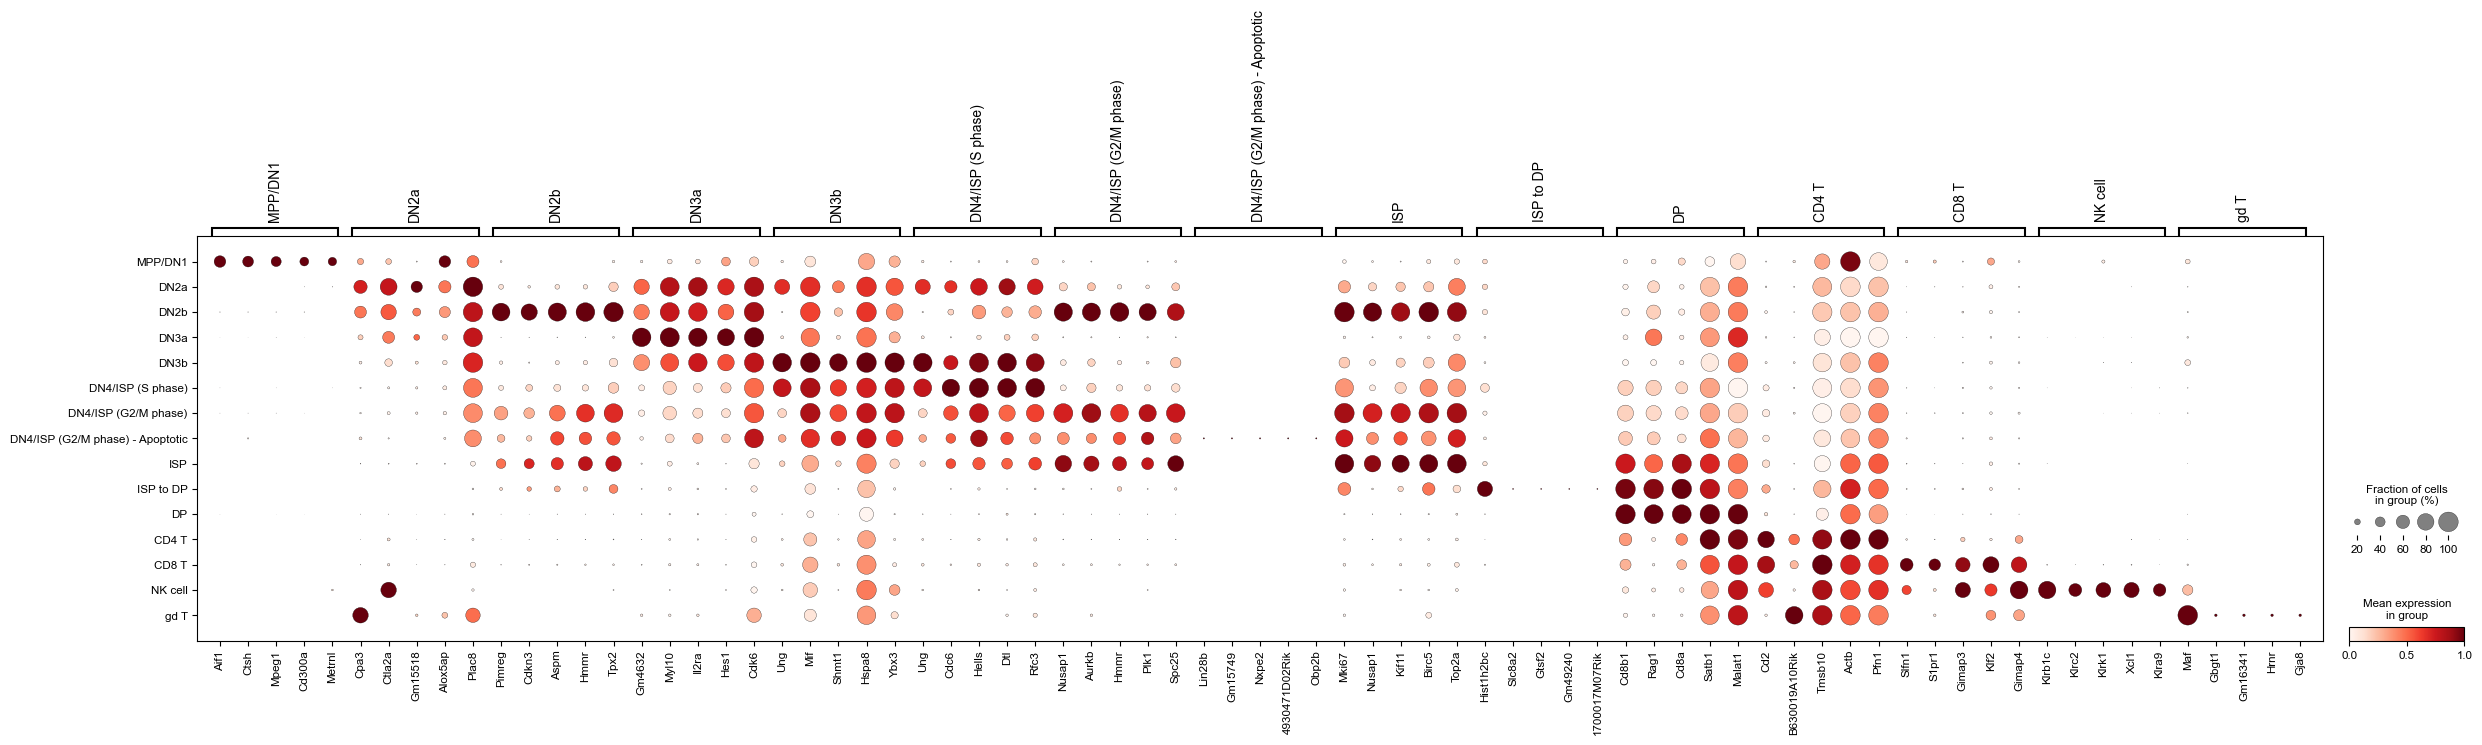

In [37]:
sc.pl.dotplot(
    adata_wt, 
    var_names=dotplot_marker_genes_dict,
    groupby=cat,
    swap_axes=False,
    dendrogram=False,
    use_raw=True,
    standard_scale='var'
)

We discussed at length in our manscript how a group of DN4/ISP cells in G2M phase were apoptotic due to their own set of lowly expressed marker genes, combined with relative high expression of mitochondrial transcipts and transcriptional similarity to the neighboring DN4/ISP cells. This transcriptonal similarity can be shown if we filter out the unique but lowly expressed marker genes.

In [38]:
# Marker dotplot
dotplot_marker_genes_dict = {}
n_markers = 5

labels = adata_wt.obs[cat].cat.categories

for l in labels:
    df = sc.get.rank_genes_groups_df(adata_wt, group=l)
    df = df[df['pct_nz_group'] >= 0.50 ].head(n_markers)

    dotplot_marker_genes_dict[l] = df['names'].to_list()

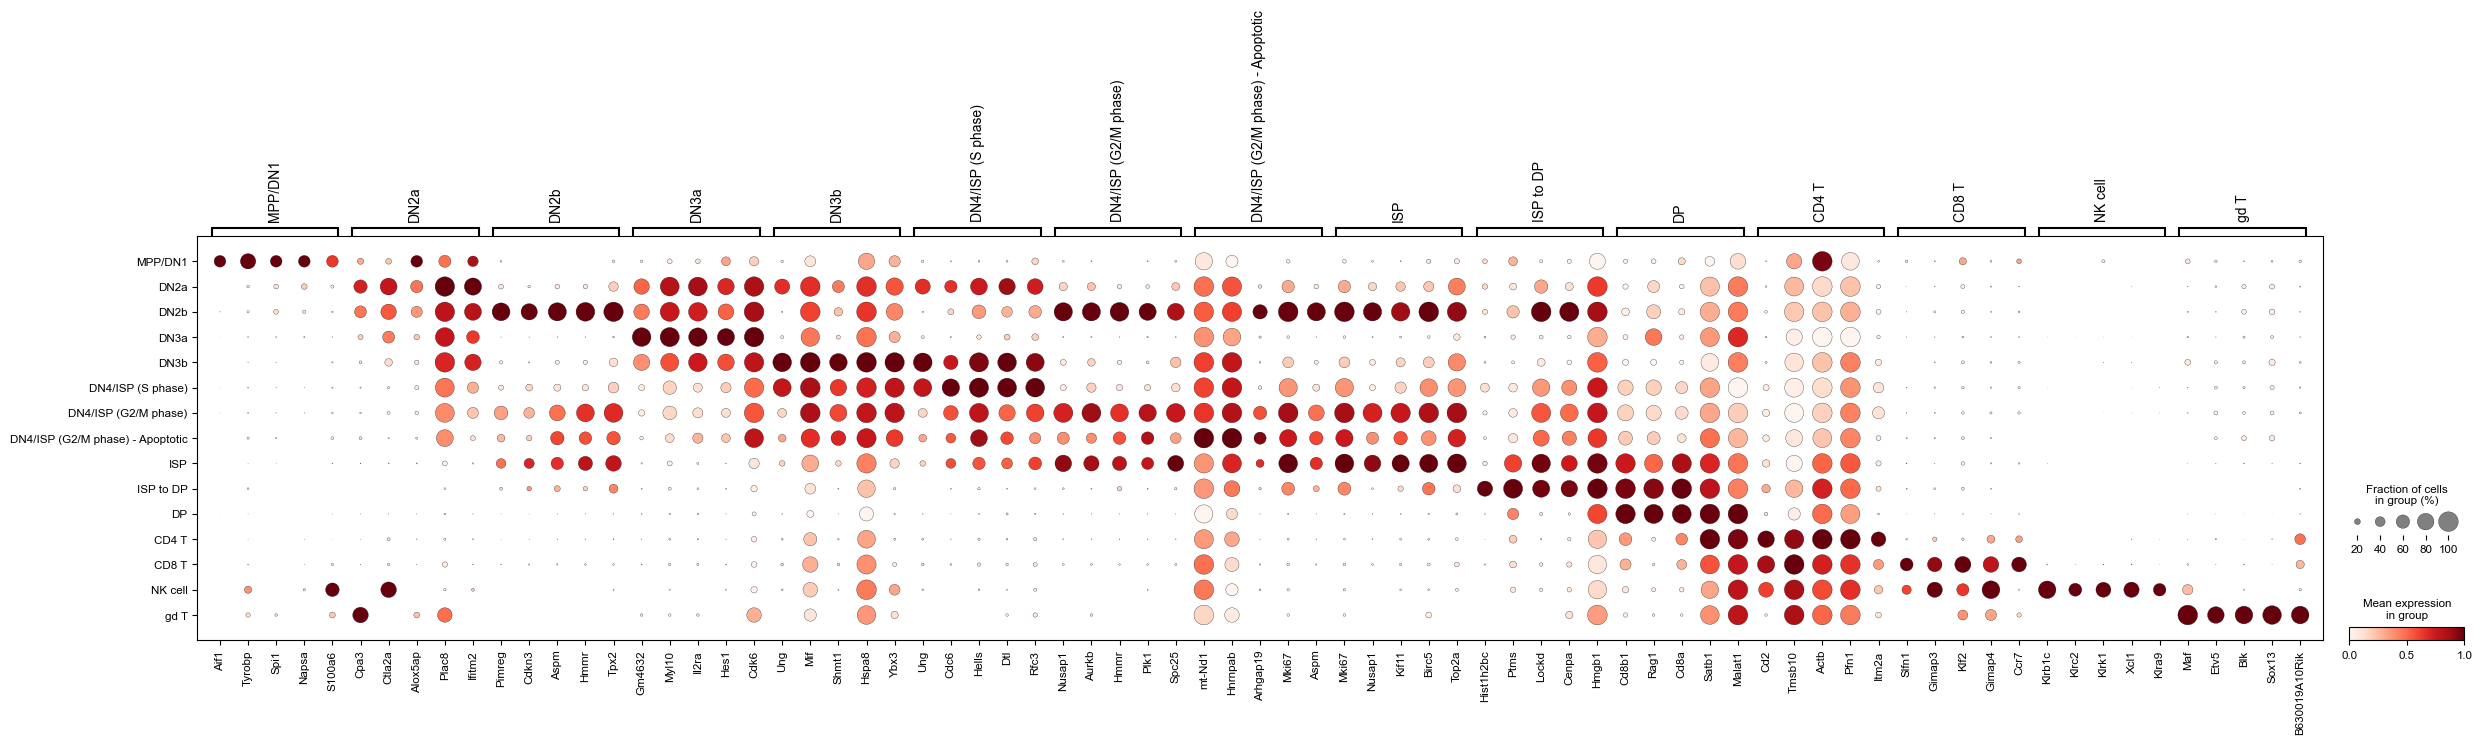

In [39]:
sc.pl.dotplot(
    adata_wt, 
    var_names=dotplot_marker_genes_dict,
    groupby=cat,
    #categories_order=categories_order,
    swap_axes=False,
    dendrogram=False,
    use_raw=True,
    standard_scale='var'
)

### Further characterization of DN4/ISP cells that are apoptotic and in the G2/M phase

Performing pairwise DE between the groups of DN4/ISP G2/M clusters revealed a relative upregulation in mitochondrial transcripts.

This figure corresponds to **Supplementary Figure 5** in our manuscript.

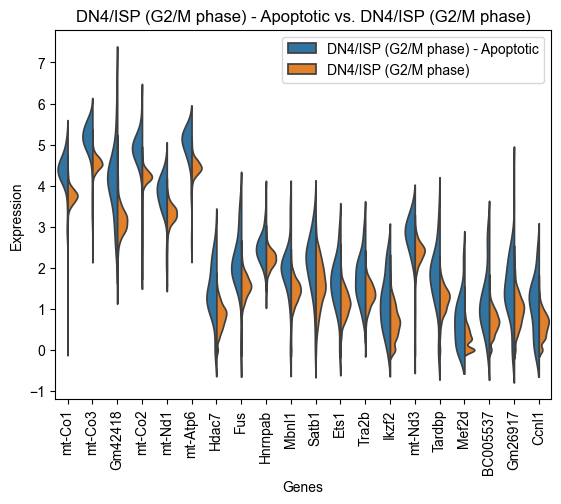

In [40]:
c1 = 'DN4/ISP (G2/M phase)'
c2 = 'DN4/ISP (G2/M phase) - Apoptotic'
category = 'final_annotation'


fig, ax = plt.subplots()

sc.tl.rank_genes_groups(adata_wt, category, groups=[c2], reference=c1, tie_correct=True, pts=True)
sc.pl.rank_genes_groups_violin(adata_wt, groups=c2, n_genes=20, ax=ax, strip=0, show=False)

ax.set_xlabel('Genes')
ax.set_ylabel('Expression')
ax.legend(loc='upper right')

plt.show()